In [1]:
import sys, os
insert_path = os.path.dirname(os.path.abspath(""))
sys.path.insert(0, insert_path)

In [12]:
from model.models.threes import ThreesModel
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from model.nba_api_helpers import get_player_shot_loc_data, get_league_shot_loc_data
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import GridSearchCV

In [48]:
bootstrap_samples = 100_000
player_df = get_player_shot_loc_data("Jordan Poole", context_measure_simple='FG3A')
threes = player_df.loc[:, ['GAME_ID', 'LOC_X', 'LOC_Y', 'SHOT_MADE_FLAG', 'SHOT_ATTEMPTED_FLAG']]
threes = threes.dropna()

threes['SHOT_MADE_FLAG'] = threes['SHOT_MADE_FLAG'].astype(np.int64)

threes_train_xy = threes[['LOC_X', 'LOC_Y']].values.reshape(-1, 2)
fga_per_game_data = threes.groupby('GAME_ID')['SHOT_ATTEMPTED_FLAG'].count().values

#get league shot data

league_df = get_league_shot_loc_data(context_measure_simple='FG3A')
league_test_xy = league_df[['LOC_X', 'LOC_Y']].values.reshape(-1, 2)

param_grid = {
    "n_components": range(2, 15),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GMM(), param_grid=param_grid, scoring=lambda estimator, x: -estimator.bic(x)
)

grid_search.fit(threes_train_xy)

covariance_type = grid_search.best_params_['covariance_type']
n_components = grid_search.best_params_['n_components']
print(n_components)
model = GMM(n_components=n_components, covariance_type=covariance_type, random_state=0).fit(threes_train_xy)

model_labels_ = model.predict(threes_train_xy)

league_model_labels_ = model.predict(league_test_xy)
league_df['cluster'] = league_model_labels_

#filter for opponent after assigning clusters
opponent_df = league_df.loc[league_df['DEF'] == opponent]

#create a dataframe from the cluster data dictionary
cluster_df = pd.DataFrame({
    'shot_made': threes['SHOT_MADE_FLAG'],
    'cluster': model_labels_
})

#shooting percentage by cluster
fg_percent_by_cluster = pd.DataFrame(cluster_df.groupby('cluster')['shot_made'].value_counts(normalize=True)).rename({'shot_made': 'fg_percent'}, axis=1).reset_index()
fg_percent_by_cluster = fg_percent_by_cluster.loc[fg_percent_by_cluster['shot_made'] == 1].drop('shot_made', axis=1)['fg_percent']

#league fg% by cluster
league_fg_percent_by_cluster = pd.DataFrame(league_df.groupby('cluster')['SHOT_MADE_FLAG'].value_counts(normalize=True)).rename({'SHOT_MADE_FLAG': 'fg_percent'}, axis=1).reset_index()
league_fg_percent_by_cluster = league_fg_percent_by_cluster.loc[league_fg_percent_by_cluster['SHOT_MADE_FLAG'] == 1].drop('SHOT_MADE_FLAG', axis=1)['fg_percent']

#opponent def fg% by cluster
opponent_fg_percent_by_cluster = pd.DataFrame(opponent_df.groupby('cluster')['SHOT_MADE_FLAG'].value_counts(normalize=True)).rename({'SHOT_MADE_FLAG': 'fg_percent'}, axis=1).reset_index()
opponent_fg_percent_by_cluster = opponent_fg_percent_by_cluster.loc[opponent_fg_percent_by_cluster['SHOT_MADE_FLAG'] == 1].drop('SHOT_MADE_FLAG', axis=1)['fg_percent']

#opponent defensive ratings per cluster relative to league average
def_adjustment = opponent_fg_percent_by_cluster / league_fg_percent_by_cluster

#bootstrap resample from FGA data to find normal distribution fo estimated mean FGA per game
fga_per_game_est = [np.random.choice(fga_per_game_data, size=len(fga_per_game_data), replace=True).mean() for _ in range(bootstrap_samples)]
fga_per_game_est_mean = np.mean(fga_per_game_est)
fga_per_game_est_std = np.std(fga_per_game_est)

3


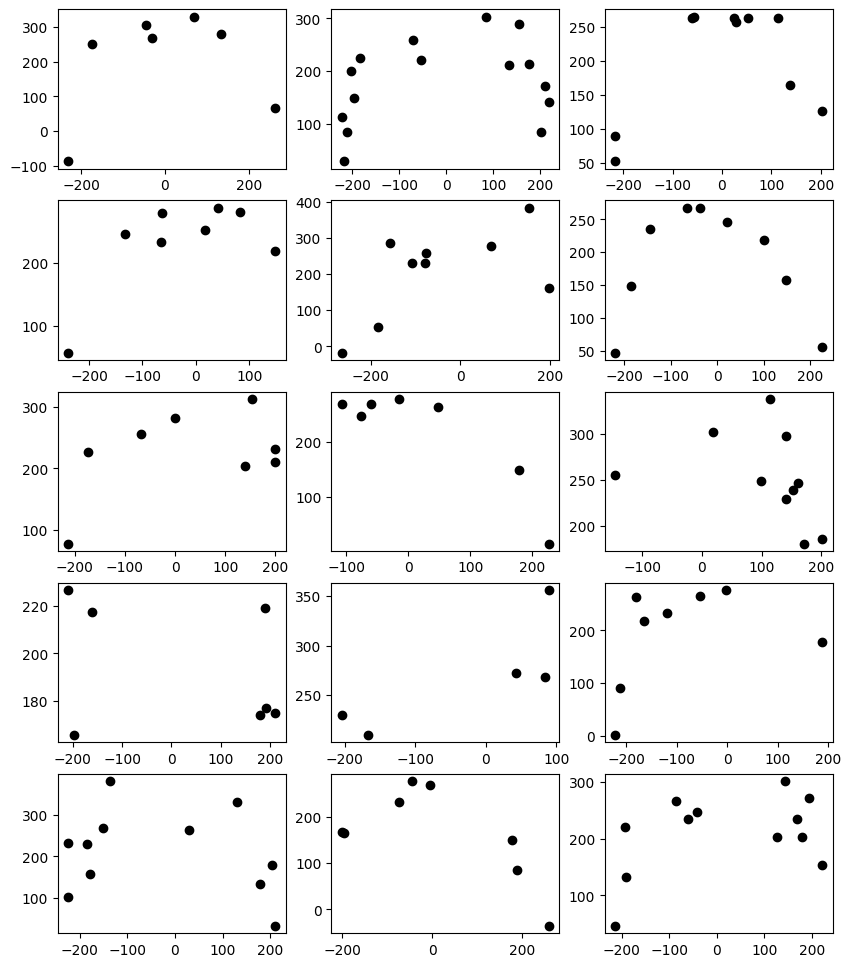

In [104]:
fig, axes = plt.subplots(5, 3, figsize=(10, 12))
for row in axes:
    for ax in row:
        #simulate FGA
        fga_i = np.random.poisson(np.random.normal(fga_per_game_est_mean, fga_per_game_est_std))
        for fga in range(fga_i):
            selected_cluster = np.random.choice(np.arange(0, n_components), p=model.weights_)
            sample_shot = np.random.multivariate_normal(
                model.means_[selected_cluster], model.covariances_[selected_cluster]
            )
            ax.scatter(x=sample_shot[0], y=sample_shot[1], color='black')

In [59]:
model.__dict__

{'n_components': 3,
 'tol': 0.001,
 'reg_covar': 1e-06,
 'max_iter': 100,
 'n_init': 1,
 'init_params': 'kmeans',
 'random_state': 0,
 'warm_start': False,
 'verbose': 0,
 'verbose_interval': 10,
 'covariance_type': 'full',
 'weights_init': None,
 'means_init': None,
 'precisions_init': None,
 'n_features_in_': 2,
 'converged_': True,
 'weights_': array([0.22941302, 0.42172992, 0.34885706]),
 'means_': array([[-201.85749724,  134.08371839],
        [ -40.07241463,  257.02968832],
        [ 173.58052943,  192.36075812]]),
 'covariances_': array([[[  651.74294097,  2049.20783256],
         [ 2049.20783256,  8435.82146195]],
 
        [[ 6714.97672302,  1069.88937031],
         [ 1069.88937031,   629.38972891]],
 
        [[ 1956.08354649, -3227.7830578 ],
         [-3227.7830578 ,  8906.39283496]]]),
 'precisions_cholesky_': array([[[ 0.03917075, -0.07043486],
         [ 0.        ,  0.02240155]],
 
        [[ 0.01220331, -0.00743744],
         [ 0.        ,  0.04667979]],
 
        [[ 0

In [74]:
model.covariances_

array([[[  651.74294097,  2049.20783256],
        [ 2049.20783256,  8435.82146195]],

       [[ 6714.97672302,  1069.88937031],
        [ 1069.88937031,   629.38972891]],

       [[ 1956.08354649, -3227.7830578 ],
        [-3227.7830578 ,  8906.39283496]]])

In [ ]:
model.

In [100]:
selected_cluster = np.random.choice(np.arange(0, n_components), p=model.weights_)
sample_shot = np.random.multivariate_normal(
    model.means_[selected_cluster], model.covariances_[selected_cluster]
)
sample_shot

array([-61.49190743, 242.88767828])

In [58]:
np.linalg.eig(model.covariances_)

(array([[  145.23444723,  8942.32995568],
        [ 6897.59103436,   446.77541758],
        [  688.31891357, 10174.15746787]]),
 array([[[-0.97078484, -0.23995163],
         [ 0.23995163, -0.97078484]],
 
        [[ 0.98574403, -0.16825194],
         [ 0.16825194,  0.98574403]],
 
        [[-0.93078025,  0.36557918],
         [-0.36557918, -0.93078025]]]))

In [71]:
np.hstack((model.means_, model.covariances_))

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 3 dimension(s)